# L0 and L1 hodge Laplcian analysis on Bitcoin OTC and Alpha 
 

In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigvalsh

alpha_df = pd.read_csv('../../soc-sign-bitcoinalpha.csv', header=None)
alpha_df.columns = ['source', 'target', 'weight', 'timestamp']

OTC_df = pd.read_csv('../../soc-sign-bitcoinotc.csv', header=None)
OTC_df.columns = ['source', 'target', 'weight', 'timestamp']

# Alpha Graph Construction
alpha_G = nx.DiGraph()
for src, tgt, _, _ in zip(alpha_df['source'], alpha_df['target'], alpha_df['weight'], alpha_df['timestamp']):
    u = int(src)
    v = int(tgt)
    alpha_G.add_edge(u, v)  # no weight for laplcian computation

# OTC graph construction
otc_G = nx.DiGraph()
for src, tgt, _, _ in zip(OTC_df['source'], OTC_df['target'], OTC_df['weight'], OTC_df['timestamp']):
    u = int(src)
    v = int(tgt)
    otc_G.add_edge(u, v)  # no weight for laplcian computation


# Convert to undirected graphs for laplcian computatio
undirected_AlphaG = alpha_G.to_undirected()
Sub_AlphaG = undirected_AlphaG.copy()

undirected_OTCG = otc_G.to_undirected()
sub_OTCG = undirected_OTCG.copy()

# Compute L0 Laplacian
L0_Alpha = nx.laplacian_matrix(undirected_AlphaG).astype(float).toarray()
L0_OTC = nx.laplacian_matrix(undirected_OTCG).astype(float).toarray()

# 5. Compute and clean eigenvalues
eigenvalues_L0 = eigvalsh(L0_Alpha)
eigenvalues_OTC = eigvalsh(L0_OTC)

print("Eigenvalues of L0 Laplacian for Alpha Graph:")
print(eigenvalues_L0)
print("Eigenvalues of L0 Laplacian for OTC Graph:")
print(eigenvalues_OTC)



Eigenvalues of L0 Laplacian for Alpha Graph:
[-2.22071307e-16  2.22044605e-16  6.66133815e-16 ...  2.64116329e+02
  2.80135739e+02  5.12020644e+02]
Eigenvalues of L0 Laplacian for OTC Graph:
[-5.26971359e-15 -2.22044605e-16  5.12379492e-16 ...  4.39150270e+02
  4.40491068e+02  7.96012014e+02]


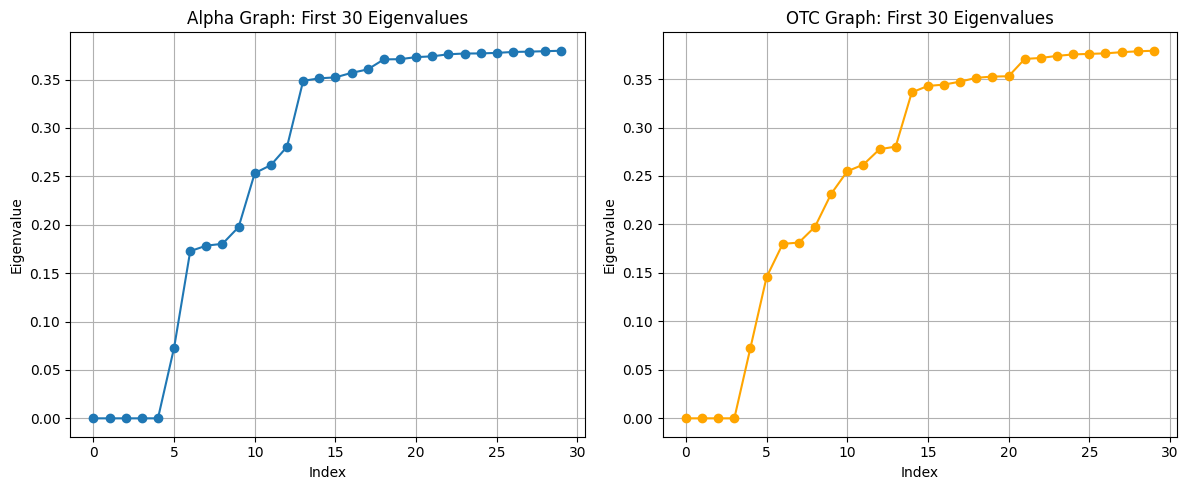

In [23]:
# Plot first 30 eigenvalues side-by-side
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(30), eigenvalues_L0[:30], marker='o')
plt.title("Alpha Graph: First 30 Eigenvalues")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(30), eigenvalues_OTC[:30], marker='o', color='orange')
plt.title("OTC Graph: First 30 Eigenvalues")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True)

plt.tight_layout()
plt.show()

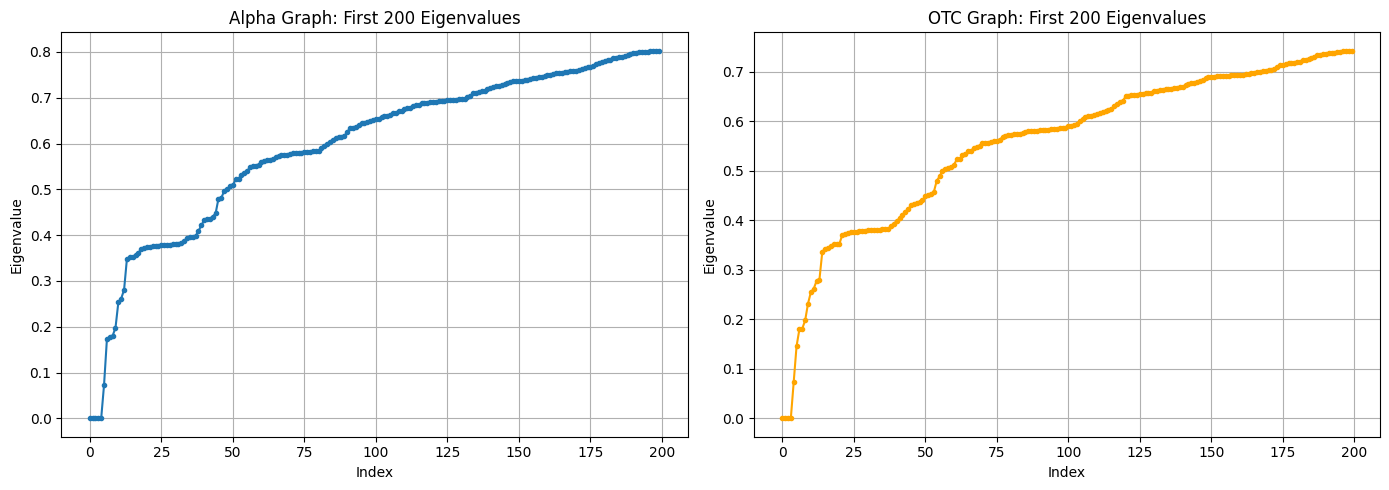

In [6]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(range(200), eigenvalues_L0[:200], marker='o', markersize=3)
plt.title("Alpha Graph: First 200 Eigenvalues")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(200), eigenvalues_OTC[:200], marker='o', color='orange', markersize=3)
plt.title("OTC Graph: First 200 Eigenvalues")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True)

plt.tight_layout()
plt.show()


In [28]:
from scipy.linalg import eigh
from sklearn.cluster import KMeans

def spectral_cluster(L, num_clusters):
    # Symmetrize just in case
    L = (L + L.T) / 2

    # Compute eigenvectors (sorted ascending)
    eigvals, eigvecs = eigh(L)

    # Select eigenvectors 1 to num_clusters (skip the 0th trivial one)
    vecs_for_clustering = eigvecs[:, 1:num_clusters+1]

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters, n_init=10)
    labels = kmeans.fit_predict(vecs_for_clustering)

    return labels


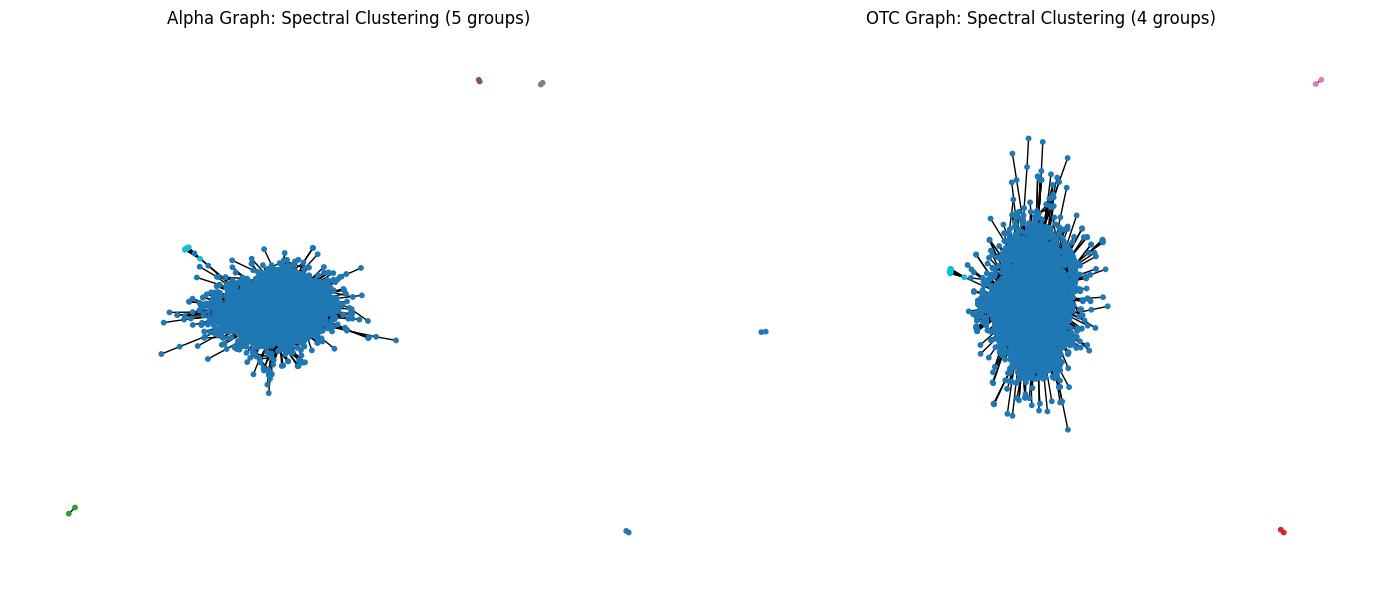

In [30]:
# Plotting the graphs with spectral clustering < * 10^15
alpha_labels = spectral_cluster(L0_Alpha, num_clusters=5)
otc_labels = spectral_cluster(L0_OTC, num_clusters=4)

# Match labels to node order used by NetworkX
alpha_nodes = list(undirected_AlphaG.nodes())
otc_nodes = list(undirected_OTCG.nodes())

alpha_node_colors = {node: alpha_labels[i] for i, node in enumerate(alpha_nodes)}
otc_node_colors = {node: otc_labels[i] for i, node in enumerate(otc_nodes)}

# Create lists of colors in node order for plotting
alpha_color_map = [alpha_node_colors[n] for n in undirected_AlphaG.nodes()]
otc_color_map = [otc_node_colors[n] for n in undirected_OTCG.nodes()]

plt.figure(figsize=(14, 6))

# Alpha graph plot
plt.subplot(1, 2, 1)
nx.draw(undirected_AlphaG, 
        node_color=alpha_color_map, 
        node_size=10, 
        with_labels=False, 
        cmap='tab10')
plt.title("Alpha Graph: Spectral Clustering (5 groups)")

# OTC graph plot
plt.subplot(1, 2, 2)
nx.draw(undirected_OTCG, 
        node_color=otc_color_map, 
        node_size=10, 
        with_labels=False, 
        cmap='tab10')
plt.title("OTC Graph: Spectral Clustering (4 groups)")

plt.tight_layout()
plt.show()


In [4]:
import random

# sample to see graph structure better

def sample_subgraph(G, labels, num_nodes=1000):
    sampled_nodes = random.sample(list(G.nodes()), min(num_nodes, G.number_of_nodes()))
    subG = G.subgraph(sampled_nodes).copy()
    sub_labels = [labels[list(G.nodes()).index(n)] for n in sampled_nodes]
    return subG, sub_labels

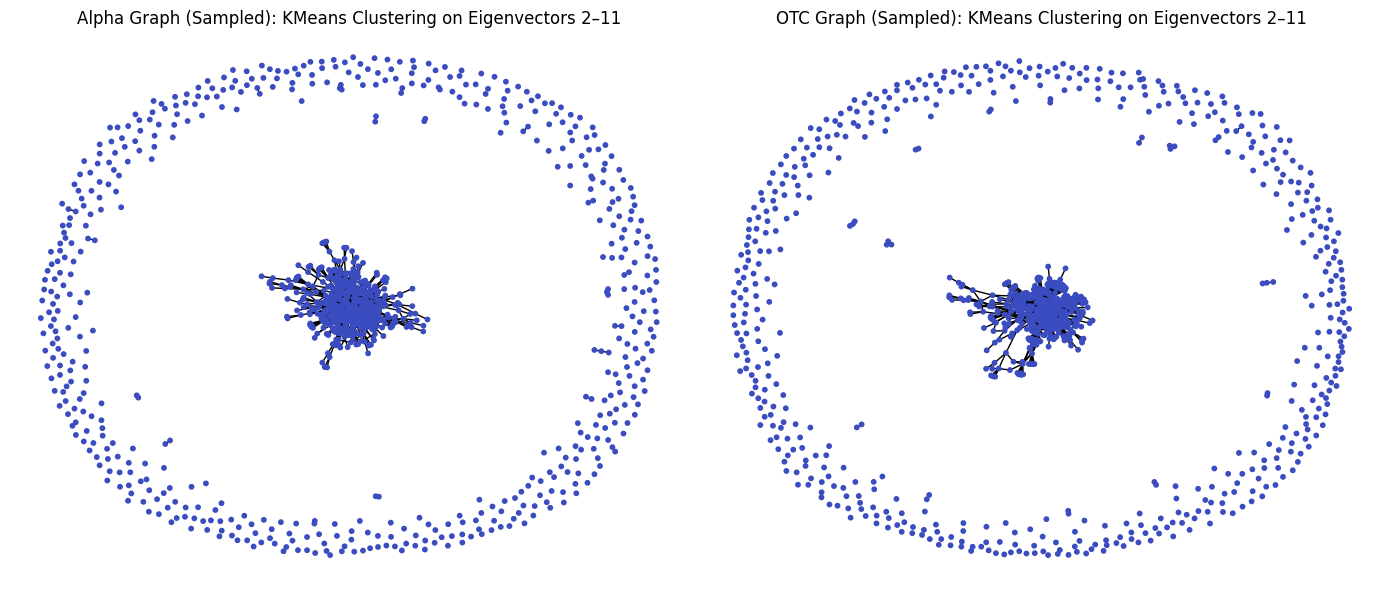

In [7]:
# 5-10 k-mean clustering on spectral embeddings

from scipy.linalg import eigh
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

# Step 1: Recalculate eigenvalues/eigenvectors
eigvals_alpha, eigvecs_alpha = eigh(L0_Alpha)
eigvals_otc, eigvecs_otc = eigh(L0_OTC)

# Step 2: Use eigenvectors 2 to 11 (index 1 to 10)
alpha_feat = eigvecs_alpha[:, 1:11]
otc_feat = eigvecs_otc[:, 1:11]

# Step 3: KMeans clustering on spectral embeddings
k = 2  # or more if you want to try more clusters
alpha_cluster = KMeans(n_clusters=k, random_state=0).fit_predict(alpha_feat)
otc_cluster = KMeans(n_clusters=k, random_state=0).fit_predict(otc_feat)

# Step 4: Sample subgraphs
alpha_subG, alpha_sub_labels = sample_subgraph(undirected_AlphaG, alpha_cluster, num_nodes=1000)
otc_subG, otc_sub_labels = sample_subgraph(undirected_OTCG, otc_cluster, num_nodes=1000)

# Step 5: Plot
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
nx.draw(alpha_subG,
        node_color=alpha_sub_labels,
        node_size=10,
        with_labels=False,
        cmap='coolwarm')
plt.title("Alpha Graph (Sampled): KMeans Clustering on Eigenvectors 2–11")

plt.subplot(1, 2, 2)
nx.draw(otc_subG,
        node_color=otc_sub_labels,
        node_size=10,
        with_labels=False,
        cmap='coolwarm')
plt.title("OTC Graph (Sampled): KMeans Clustering on Eigenvectors 2–11")

plt.tight_layout()
plt.show()


## L1 Hodge Laplcian
### Betty number 1, holes 

What do the holes represent?

In [14]:
from scipy.sparse import csr_matrix
import numpy as np
import networkx as nx

def compute_hodge_1_laplacian(G):
    # Sort edges so everything is consistently oriented
    edges = [tuple(sorted(e)) for e in G.edges()]
    nodes = list(G.nodes())
    node_index = {node: i for i, node in enumerate(nodes)}
    edge_index = {e: i for i, e in enumerate(edges)}

    num_edges = len(edges)
    num_nodes = len(nodes)
    
    # Build B1 (edge-node incidence matrix)
    row, col, data = [], [], []
    for i, (u, v) in enumerate(edges):
        row.extend([i, i])
        col.extend([node_index[u], node_index[v]])
        data.extend([+1, -1])  # arbitrary orientation, consistent since edges are sorted

    B1 = csr_matrix((data, (row, col)), shape=(num_edges, num_nodes))
    L1_down = B1 @ B1.T  # edge-edge: node-based connectivity

    # Detect triangles (as sets of 3 fully connected nodes)
    triangles = set()
    for u in G.nodes():
        neighbors = list(G.neighbors(u))
        for i in range(len(neighbors)):
            for j in range(i + 1, len(neighbors)):
                v, w = neighbors[i], neighbors[j]
                if G.has_edge(v, w):
                    triangle = tuple(sorted([u, v, w]))
                    triangles.add(triangle)

    triangle_list = list(triangles)
    row, col, data = [], [], []
    
    # Build B2 (triangle-edge incidence matrix)
    for t_idx, (a, b, c) in enumerate(triangle_list):
        for u, v in [(a, b), (b, c), (c, a)]:
            e = tuple(sorted((u, v)))
            if e in edge_index:
                e_idx = edge_index[e]
                row.append(t_idx)
                col.append(e_idx)
                data.append(1)  # unweighted, unsigned

    B2 = csr_matrix((data, (row, col)), shape=(len(triangle_list), num_edges))
    L1_up = B2.T @ B2  # edge-edge: triangle-based connectivity

    # Final L1 = down + up
    L1 = L1_down + L1_up
    return L1.toarray()




In [ ]:
from numpy.linalg import eigvalsh

# Alpha graph
G_alpha = undirected_AlphaG
L1_alpha = compute_hodge_1_laplacian(G_alpha)
eigvals_alpha = eigvalsh(L1_alpha)
print("Alpha L1 shape:", L1_alpha.shape)
print("Alpha eigenvalues (L1):", eigvals_alpha)

# OTC graph
G_otc = undirected_OTCG
L1_otc = compute_hodge_1_laplacian(G_otc)
eigvals_otc = eigvalsh(L1_otc)
print("OTC L1 shape:", L1_otc.shape)
print("OTC eigenvalues (L1):", eigvals_otc)


Alpha L1 shape: (14124, 14124)
Alpha eigenvalues (L1): [-3.10862447e-14 -2.48689958e-14 -2.47280495e-14 ...  2.87485907e+02
  2.94022556e+02  5.18331279e+02]


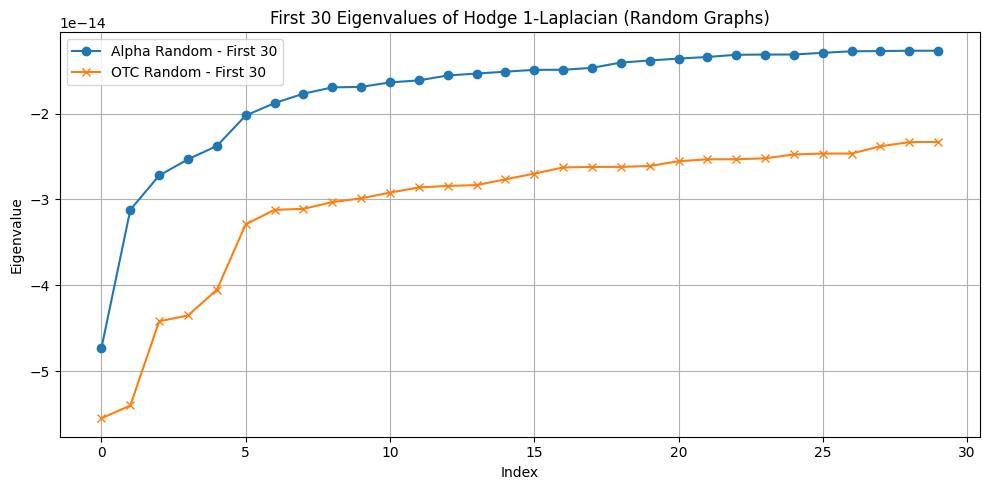

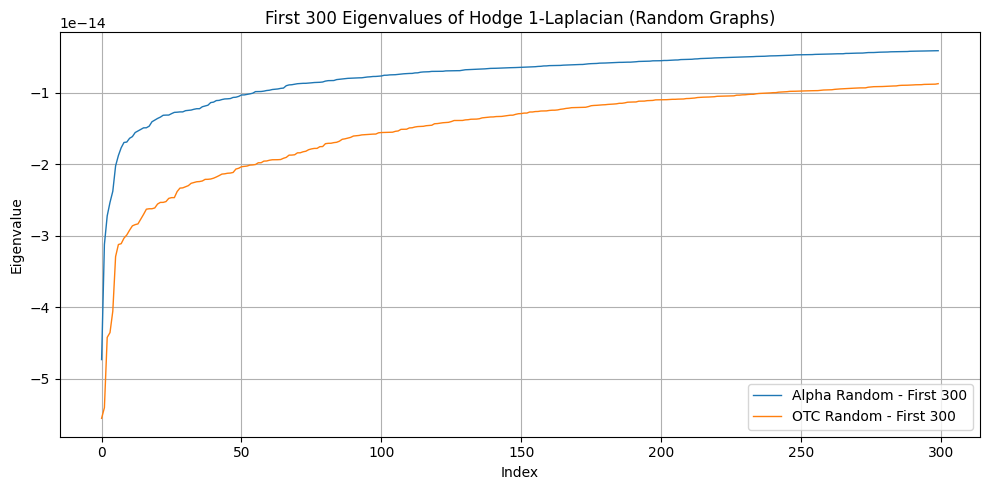

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(eigvals_alpha[:30], label='Alpha Random - First 30', marker='o')
plt.plot(eigvals_otc[:30], label='OTC Random - First 30', marker='x')
plt.title('First 30 Eigenvalues of Hodge 1-Laplacian (Random Graphs)')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot first 300 eigenvalues
plt.figure(figsize=(10, 5))
plt.plot(eigvals_alpha[:300], label='Alpha Random - First 300', linewidth=1)
plt.plot(eigvals_otc[:300], label='OTC Random - First 300', linewidth=1)
plt.title('First 300 Eigenvalues of Hodge 1-Laplacian (Random Graphs)')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()